# Read and Write SEGY files with pysegy

This tutorial demonstrates how to read existing SEGY data shipped with the repository and how to write new files using **pysegy**. We use one of the example files located in the `data` directory.

In [1]:
import sys
sys.path.append('..')  # allow importing the local pysegy package
import pysegy as seg
import fsspec
import matplotlib.pyplot as plt

## Read a SEGY file
We first load the file using `segy_read` without specifying a filesystem.

In [2]:
path = '../data/overthrust_2D_shot_1_20.segy'
block = seg.segy_read(path)
print('Samples per trace:', block.fileheader.bfh.ns)
print('Number of traces:', len(block.traceheaders))

Reading SEGY file ../data/overthrust_2D_shot_1_20.segy


Loaded header ns=751 dt=4000 from ../data/overthrust_2D_shot_1_20.segy
Samples per trace: 751
Number of traces: 3300


The first trace header contains a variety of fields. Here we display a few common values.

In [3]:
hdr = block.traceheaders[0]
print('SourceX:', hdr.SourceX)
print('GroupX:', hdr.GroupX)
print('ns:', hdr.ns)

SourceX: 400
GroupX: 100
ns: 751


### Visualise a trace
The trace data are stored in a NumPy array. The following plot shows the amplitudes of the first trace.

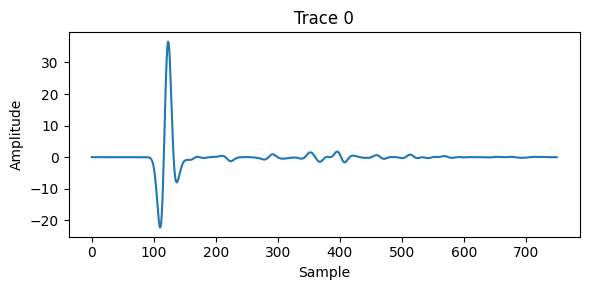

In [4]:
plt.figure(figsize=(6,3))
plt.plot(block.data[:,0])
plt.title('Trace 0')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

### Visualise the whole gather
Using `imshow` helps see the shot as an image.

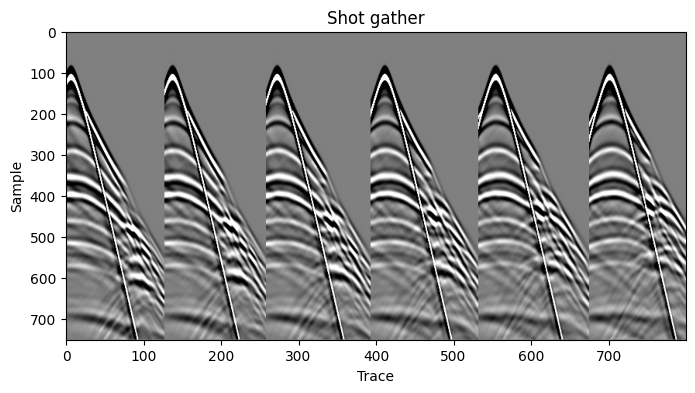

In [5]:
plt.figure(figsize=(8,4))
plt.imshow(block.data[:, :800], aspect='auto', cmap='gray', vmin=-1e0, vmax=1e0)
plt.title('Shot gather')
plt.xlabel('Trace')
plt.ylabel('Sample')
plt.show()

## Write a new file
We create a small subset containing the first 20 traces and write it to a temporary file.

In [6]:
subset = seg.SeisBlock(block.fileheader, block.traceheaders[:20], block.data[:, :20])
out_path = 'subset.segy'
seg.segy_write(out_path, subset)
# reload to verify
out = seg.segy_read(out_path)
print('Wrote and reloaded', out_path, 'with', len(out.traceheaders), 'traces')

Writing SEGY file subset.segy
Finished writing subset.segy
Reading SEGY file subset.segy
Loaded header ns=751 dt=4000 from subset.segy
Wrote and reloaded subset.segy with 20 traces


## Using fsspec filesystems
The same functions work with any filesystem that follows the `fsspec` interface. Here we use the local `file` implementation.

In [7]:
fs = fsspec.filesystem('file')
block_fs = seg.segy_read(path, fs=fs)
print('Read with filesystem, ns =', block_fs.fileheader.bfh.ns)
fs_path = 'subset_fs.segy'
seg.segy_write(fs_path, subset, fs=fs)
reloaded = seg.segy_read(fs_path, fs=fs)
print('Reloaded via fs, traces =', len(reloaded.traceheaders))

Reading SEGY file ../data/overthrust_2D_shot_1_20.segy


Loaded header ns=751 dt=4000 from ../data/overthrust_2D_shot_1_20.segy
Read with filesystem, ns = 751
Writing SEGY file subset_fs.segy
Finished writing subset_fs.segy
Reading SEGY file subset_fs.segy
Loaded header ns=751 dt=4000 from subset_fs.segy
Reloaded via fs, traces = 20


## Scan the full dataset
We can scan all the overthrust files and access each shot without loading everything at once.

In [8]:
import contextlib, io
with contextlib.redirect_stdout(io.StringIO()):
    scan = seg.segy_scan('../data', 'overthrust_2D_shot_*.segy', threads=1)
print('Shots found:', len(scan))

Shots found: 97


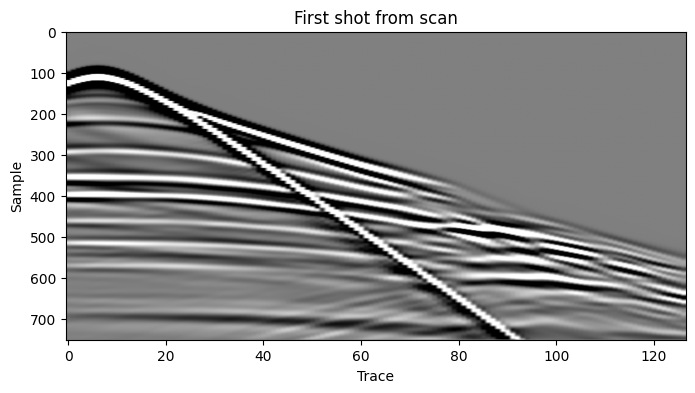

In [9]:
first = scan[0]
plt.figure(figsize=(8,4))
plt.imshow(first.data, aspect='auto', cmap='gray', vmin=-1e0, vmax=1e0)
plt.title('First shot from scan')
plt.xlabel('Trace')
plt.ylabel('Sample')
plt.show()

In [10]:
assert block.fileheader.bfh.ns == block.data.shape[0]
assert len(block.traceheaders) == block.data.shape[1]